# Is the Swiss franc a safe haven for US investors during recessions?


## Table of Contents

#### 1. Introduction

#### 2. Theory

#### 3. Empirical Study

#### 4. Conclusion


## 1. Introduction

Recessions are a part of the economy that have seemingly been inevitable since the Karl Marx first introduced the concept of the "Boom and Bust" cycles. Although exactly what leads to a recession is not always clear ahead of time (or even after the fact to some), what is true in our capitalist society, we don't seem to be able to avoid them. Hence, it is vital for investors to know how to protect themselves in case such a recession rises, should they not wish to incurr substantial losses of capital. 

There are various assets throughout history that have been claimed to exhibit said property of protecting investors during recessions, such as gold or certain government bonds. However, recessions can differ greatly from one another and hence it may not be true than asset which retained its value (or even appreciated) in one recession will do so in another. We aim to test the hypothesis that the Swiss Franc is one of these aforementioned safe haven assets, and we will do so by taking a closer look at it's price action in previous recessions.

## 2. Theory

In order to measure the dependence of two time series one cannot simply compute the correlation or a regression coefficient since the time series itselfes may have autocorrelation. Therefore, one normally first tries to make the time series stationary by either detrending and deseasonalizing or by differencing. Detrending means to substract a trend which can be for example estimated by an OLS regression. Differencing simply means to transform the old time series $(X_t)$ into the new time series $(Y_t)$ where $X_t = Y_t - Y_{t-1}$. To check for stationarity, one often uses the augmented Dickey-Fuller (ADF) test. The ADF test is a unit root test which means that the null hypothesis is that the time series has a unit root and therefore is stationary. 

...

## 3. Empirical Study

In this section we conduct an empirical study where we use data from the S&P 500 index and from the USD/CHF exchange rate during recession periods in order to evaluate wether the safe haven effect is present. 

We focus on the recessions of the last 40 years namely:
1. July 1981- November 1982
2. July 1990 - March 1991
3. March 2001 - November 2001
4. December 2007 - June 2009
5. February 2020 - April 2020. 

Using the S&P 500 returns over these periods and the exchange rate USD/CHF, we investigate wether there is a significant correlation which could be exploited as an alternative and safe investment during recessions.

As a first step, we need to load relevant libraries which are used throughout:
- **datetime**: for date handling and manipulation
- **matplotlib**: for plotting
- **numpy**: for data smoothing
- **scipy.stats**: for finding the pearson correlation
- **pandas**: to easily work with the data
- **yfinance**: to obtain historical stock price data
- **math**: to use mathematical functions (e.g. ```log(...)```)
- **detrend**: to detrend time series
- **adfuller**: for stationarity test (augmented dickey fuller)
- **AutoReg**: to fit an AR model
- **sm**: to calculate cross-correlation
- **widgetsnbextension, ipywidgets**: to create interactive plots
- **PrettyTable**: to create tables

In [270]:
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import yfinance
import math
from statsmodels.tsa.stattools import adfuller
from scipy.signal import detrend
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
import widgetsnbextension
import ipywidgets
from prettytable import PrettyTable
from seaborn import heatmap
import prettytable

Through Yahoo! Finance API "wrapper" (yfinance) we create a function to obtain historical data of an asset price at close and return it as a pandas dataframe object. This function can be used to obtain other data (ticker) for different periods (start_date, end_date) and different frequency.

In [246]:
"""
   Returns historical data of the closing price of ticker between start and end.
   If not passed in, start is set to 01/01/1900 and end the date of today.
   Another optional argument is the frequency which is set to 1 day by default.

   :param string ticker: ticker of the asset which must match the one in yahoo finance
   :param string start: start date of the historical data to be retrived
   :param string end: end date of the historical data to be retrived
   :param string frequency: the epoch between each data point
   :return: historical price at close of ticker between start and end
   :rtype: pandas dataframe
"""
def get_historical_data(ticker, start_date="1900-01-01", end_date=datetime.today().strftime("%Y-%m-%d"), frequency="1d"):
    if start_date > end_date:
        raise Exception("start date cannot be before end date")
    asset = yfinance.Ticker(ticker)
    stock_history = asset.history(period="max", interval=frequency)
    stock_history['Date'] = stock_history.index.strftime("%Y-%m-%d")
    stock_history.reset_index(drop=True, inplace=True)
    filtered_data = stock_history.loc[(stock_history["Date"] >= start_date) & (
        stock_history["Date"] <= end_date)][["Date", "Close"]]

    return filtered_data

In theory, we could make use of the function ```get_historical_data(...)``` to obtain historical rates for the pair USD/CHF. However, the earliest data point starts in 2003 which would not be enough to analyze the first three recessions. Therefore, we load an excel file to a pandas dataframe with the historical rates of the pair considered. The data was retrieved from Bloomberg.

In [247]:
"""
   Returns historical data of the closing price of the pair USD/CHF between start and end.
   If not passed in, start is set to 01/01/1900 and end the date of today.

   :param string start: start date of the historical data to be retrived
   :param string end: end date of the historical data to be retrived
   :return: historical price at close of ticker between start and end
   :rtype: pandas dataframe
"""
def load_USDCHF_historical_data(start_date="1900-01-01", end_date=datetime.today().strftime("%Y-%m-%d")):
    if start_date > end_date:
        raise Exception("start date cannot be before end date")
    pair_data = pd.read_excel("USDCHF.xlsx").sort_values(by="Date", ascending=True)
    pair_data["Date"] = pair_data["Date"].map(lambda x: x.strftime("%Y-%m-%d"))
    return pair_data.loc[(pair_data["Date"] >= start_date) & (
        pair_data["Date"] <= end_date)][["Date", "Close"]]


The following function ```log_returns(...)``` calculates log-returns and defines a mapping to be used in the dataframe manipulation. This will be the first thing we do with our data.

In [248]:
def log_returns(stock_prices):
    mapping = {stock_prices[0] : 0}
    for i in range(1, len(stock_prices)):
        mapping[stock_prices[i]] = math.log(stock_prices[i] / stock_prices[i-1])
    return mapping

Now we can start with our study by obtaining all the relevant data for all the 5 recessions and ensure that the dates match (CHF/USD had more data points than SPX which needed to be removed).

In [249]:
recession_dates = [["1981-07-01", "1982-11-01"],
                   ["1990-07-01", "1991-03-01"],
                   ["2001-03-01", "2001-11-01"],
                   ["2007-12-01", "2009-06-01"],
                   ["2020-02-01", "2020-04-30"]]

spx_yf_ticker = "^GSPC"
spx_historical_data = {}
fx_pair_historical_data = {}
n_recession = 0

for recession_date in recession_dates:
    n_recession += 1
    start_date = recession_date[0]
    end_date = recession_date[1]
    
    spx_data = get_historical_data(spx_yf_ticker, start_date, end_date)
    pair_data = load_USDCHF_historical_data(start_date, end_date)

    # replace stock prices with log returns 
    spx_data["Close"] = spx_data["Close"].map(
        log_returns(list(spx_data["Close"])))
    spx_data.index = range(len(spx_data.index))

    
    # clean fx pair data
    pair_data = pair_data[pair_data["Date"].isin(spx_data["Date"])]
    # similarly for pair rates, replace with log returns
    pair_data["Close"] = pair_data["Close"].map(
        log_returns(list(pair_data["Close"])))
    pair_data.index = range(len(pair_data.index))

    spx_historical_data[f"recession {n_recession}"] = spx_data
    fx_pair_historical_data[f"recession {n_recession}"] = pair_data

For each recession we visualize the returns of SPX and USD/CHF. Note that this also serves as a sanity check.

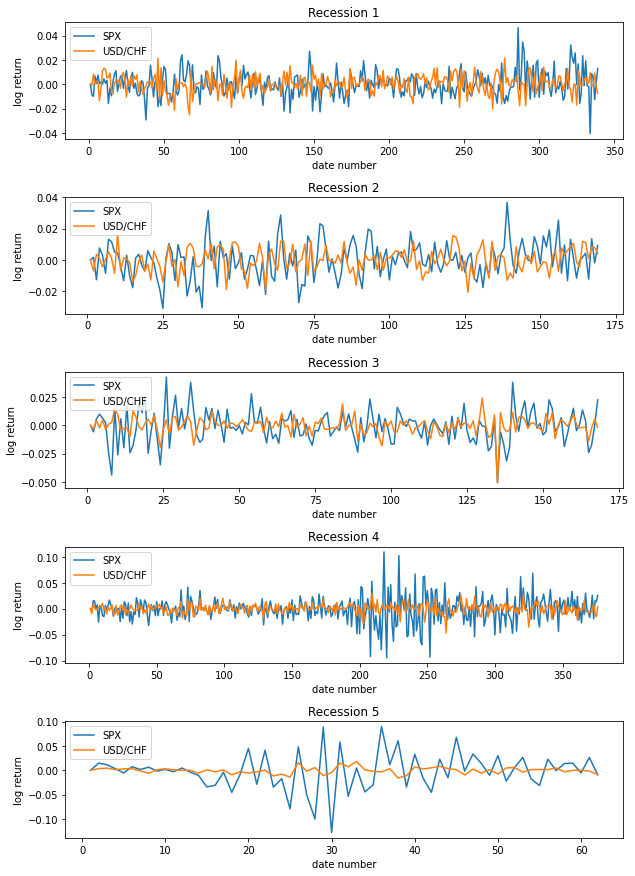

In [250]:
fig, axs = plt.subplots(5, figsize=(10, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0.9})

for i in range(len(recession_dates)):
    date_nr = list(
        range(1, len(spx_historical_data[f"recession {i+1}"]["Date"]) + 1))
    axs[i].plot(
        date_nr, list(spx_historical_data[f"recession {i+1}"]["Close"]))
    axs[i].plot(
        date_nr, list(fx_pair_historical_data[f"recession {i+1}"]["Close"]))
    axs[i].legend(["SPX", "USD/CHF"], loc='upper left')
    axs[i].set_ylabel('log return')
    axs[i].set_xlabel('date number')
    axs[i].set_title(f'Recession {i+1}')


Since the data has very high fluctuations as one can see in the figures, we use a low-pass filter to smooth the data, specifically a moving average filter and plot the time series again. An alternative to the low-pass filter could also be a Kalman filter.

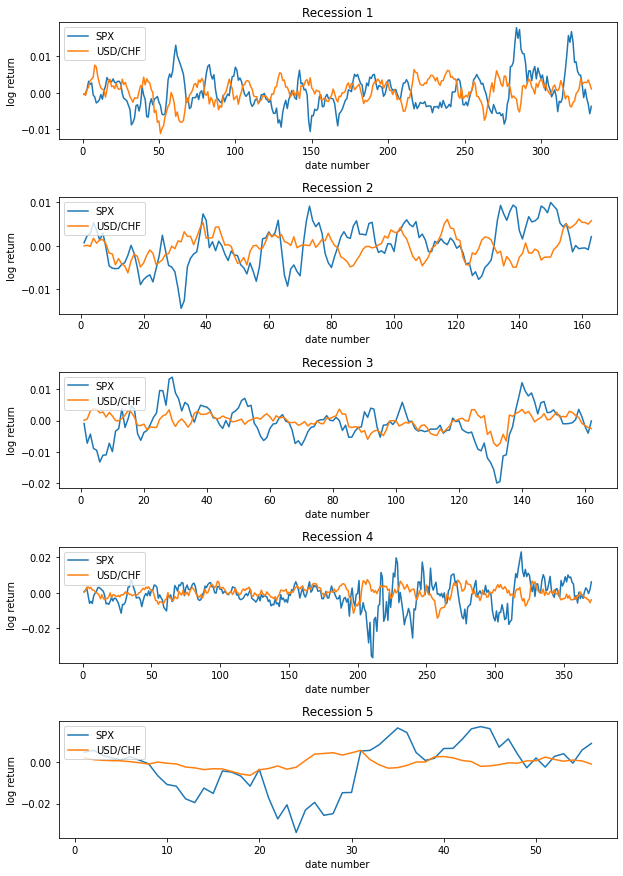

In [251]:
from scipy.stats import spearmanr

fig, axs = plt.subplots(5, figsize=(10, 15), gridspec_kw={
                        'hspace': 0.5, 'wspace': 0.9})

smoothed_data_per_recession = []

for i in range(len(recession_dates)):
    X = list(spx_historical_data[f"recession {i+1}"]["Close"])
    Y = list(fx_pair_historical_data[f"recession {i+1}"]["Close"])

    # moving average (7 day window)
    smoothed_data_X = np.convolve(X, np.ones((7,))/7, mode='valid')
    smoothed_data_Y = np.convolve(Y, np.ones((7,))/7, mode='valid')

    smoothed_data_per_recession.append([smoothed_data_X, smoothed_data_Y])
    
    date_nr = list(
        range(1, len(smoothed_data_X) + 1))
    axs[i].plot(
        date_nr, list(smoothed_data_X))
    axs[i].plot(
        date_nr, list(smoothed_data_Y))
    axs[i].legend(["SPX", "USD/CHF"], loc='upper left')
    axs[i].set_ylabel('log return')
    axs[i].set_xlabel('date number')
    axs[i].set_title(f'Recession {i+1}')


After obtaining smoothed data, we now check for stationarity using the beforementioned ADF test.

In [252]:
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    return dftest[1]

In [253]:
p_values_fx = []
p_values_spx = []
for i in range(len(recession_dates)):
    p_values_fx.append(adf_test(smoothed_data_per_recession[i][0]))
    p_values_spx.append((adf_test(smoothed_data_per_recession[i][1])))

# Create table
myTable = PrettyTable(["","Recession 1", "Recession 2", "Recession 3", "Recession 4", "Recession 5"])
p_values_fx = [round(x, 3) for x in p_values_fx]
p_values_spx = [round(x, 3) for x in p_values_spx]
p_values_fx.insert(0, "CHF/USD")
p_values_spx.insert(0, "S&P 500")
myTable.add_row(p_values_fx)
myTable.add_row(p_values_spx)

print("P-Values of augmented Dickey-Fuller test:")
print(myTable)


P-Values of augmented Dickey-Fuller test:
+---------+-------------+-------------+-------------+-------------+-------------+
|         | Recession 1 | Recession 2 | Recession 3 | Recession 4 | Recession 5 |
+---------+-------------+-------------+-------------+-------------+-------------+
| CHF/USD |    0.023    |    0.494    |    0.093    |    0.002    |    0.385    |
| S&P 500 |    0.014    |    0.054    |    0.065    |     0.0     |    0.155    |
+---------+-------------+-------------+-------------+-------------+-------------+


As one can observe, the data for the second and third recession is not stationary. Therefore, we detrend the data and check again for stationarity.

In [254]:
stationary_data_per_recession = smoothed_data_per_recession
stationary_data_per_recession[1][0] = detrend(stationary_data_per_recession[1][0],type = "linear")
stationary_data_per_recession[1][1] = detrend(stationary_data_per_recession[1][1],type = "linear")
stationary_data_per_recession[2][0] = detrend(stationary_data_per_recession[2][0],type = "linear")
stationary_data_per_recession[2][1] = detrend(stationary_data_per_recession[2][1],type = "linear")
stationary_data_per_recession[4][0] = detrend(stationary_data_per_recession[4][0],type = "linear")
stationary_data_per_recession[4][1] = detrend(stationary_data_per_recession[4][1],type = "linear")


p_values_fx = []
p_values_spx = []
for i in range(len(recession_dates)):
    p_values_fx.append(adf_test(stationary_data_per_recession[i][0]))
    p_values_spx.append((adf_test(stationary_data_per_recession[i][1])))

# Create table
myTable = PrettyTable(["","Recession 1", "Recession 2", "Recession 3", "Recession 4", "Recession 5"])
p_values_fx = [round(x, 3) for x in p_values_fx]
p_values_spx = [round(x, 3) for x in p_values_spx]
p_values_fx.insert(0, "CHF/USD")
p_values_spx.insert(0, "S&P 500")
myTable.add_row(p_values_fx)
myTable.add_row(p_values_spx)

print("P-Values of augmented Dickey-Fuller test:")
print(myTable)

P-Values of augmented Dickey-Fuller test:
+---------+-------------+-------------+-------------+-------------+-------------+
|         | Recession 1 | Recession 2 | Recession 3 | Recession 4 | Recession 5 |
+---------+-------------+-------------+-------------+-------------+-------------+
| CHF/USD |    0.023    |    0.069    |    0.079    |    0.002    |    0.043    |
| S&P 500 |    0.014    |    0.047    |    0.079    |     0.0     |    0.071    |
+---------+-------------+-------------+-------------+-------------+-------------+


One can see that the fx data for the two critical recessions is still does not pass the test on a $\alpha = 5\%$ level. Therefore, we allow to difference the series once in our evaluations.

In [255]:
def difference_ts(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

With the following function ```get_AR_residuals(...)``` we fit multiple Autoregressive models with $p \in \{2,3,...,6\}$ and pick the best one according to the Akaike Information Criterion (AIC). Based on the best model we calculate the residuals.

In [256]:
def get_AR_residuals(data_fx, data_spx):
    residuals_fx = []
    residuals_spx = []
    best_aic = 0
    # find AR models with lowest sum of AIC (consider p = 2,...,6) -> need to have same p, otherwise data does not have same len
    for _lags in range(2,7):
        AR_fit_fx = AutoReg(data_fx, _lags).fit()
        AR_fit_spx = AutoReg(data_spx, _lags).fit()
        sum_aic = AR_fit_fx.aic + AR_fit_spx.aic
        if sum_aic < best_aic:
            final_AR_fx = AR_fit_fx
            final_AR_spx = AR_fit_spx
            best_aic = sum_aic
    residuals_fx.append(final_AR_fx.resid)
    residuals_spx.append(final_AR_spx.resid)
    return (residuals_fx[0], residuals_spx[0])

For each recession we find the cross-correlation and the spearman correlation. For this we create an interactive plot that let's the user try out stuff by himself. One can apply the operations (detrending and differencing) to the data and calculate the (cross-) correlation based on teh data or on the residuals from an AR model.

In [257]:
def corr_interact(detrend, difference, AR):
    cross_correlations = np.zeros([len(recession_dates), 5])
    correlations = []
    p_values = []
    for i in range(len(recession_dates)):
        if AR:
            if detrend and difference:
                X, Y = get_AR_residuals(difference_ts(stationary_data_per_recession[i][0]), difference_ts(stationary_data_per_recession[i][1]))   
            if detrend:
                X, Y = get_AR_residuals(stationary_data_per_recession[i][0], stationary_data_per_recession[i][1])
            elif difference:
                X, Y = get_AR_residuals(difference_ts(smoothed_data_per_recession[i][0]), difference_ts(smoothed_data_per_recession[i][1]))
            else:
                X,Y = get_AR_residuals(smoothed_data_per_recession[i][0], smoothed_data_per_recession[i][1])
                
        else:
            if detrend and difference:
                X = difference_ts(stationary_data_per_recession[i][0])
                Y = difference_ts(stationary_data_per_recession[i][1])
            if detrend:
                X = stationary_data_per_recession[i][0]
                Y = stationary_data_per_recession[i][1]
            elif difference:    
                X = difference_ts(smoothed_data_per_recession[i][0])
                Y = difference_ts(smoothed_data_per_recession[i][1])
            else: 
                X = smoothed_data_per_recession[i][0]
                Y = smoothed_data_per_recession[i][1]
        
        cross_corr = sm.tsa.stattools.ccf(X, Y, adjusted = False)
        print(f"Cross-Correlation for Recession {i+1}: {cross_corr[0:5]}")
        cross_correlations[i,:] = [round(x, 3) for x in cross_corr[0:5]]
        pearson_corr, pearson_p_value = pearsonr(X, Y)
        correlations.append(pearson_corr)
        p_values.append(pearson_p_value)
        #print(f"Recession {i+1}:\n\tCorrelation: {pearson_corr},\n\t P-value:    {pearson_p_value}")
        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        ax1.xcorr(X, Y, usevlines=True,
              maxlags=5, normed=True,
              lw=2)
        # adding grid to the graph
        ax1.grid(True)
        ax1.axhline(0, color='blue', lw=2)
 
        # show final plotted graph
        plt.show()   
        
    # Create table
    myTable = PrettyTable(["","Recession 1", "Recession 2", "Recession 3", "Recession 4", "Recession 5"])
    correlations = [round(x, 3) for x in correlations]
    p_values = [round(x, 3) for x in p_values]
    correlations.insert(0, "Correlation")
    p_values.insert(0, "P-Value")
    myTable.add_row(correlations)
    myTable.add_row(p_values)

    print("Pearson Correlation and corresponding p-values:")
    print(myTable)
    
    plt.figure(figsize = (12, 5))
    heatmap(cross_correlations, xticklabels = ["Lag 1", "Lag 2", "Lag 3", "Lag 4", "Lag 5"], 
            yticklabels = ["Recession 1", "Recession 2", "Recession 3", "Recession 4", "Recession 5"], 
            cmap = 'RdBu', annot = True)
    plt.title('Cross-Correlation S&P 500 and CHF/USD)')
    plt.show()
    
    
x = ipywidgets.interact(corr_interact, 
    detrend = ipywidgets.Checkbox(
        value=True,
        description='apply linear detrending',
        disabled=False,
        indent=False), 
    difference = ipywidgets.Checkbox(
        value=True,
        description='apply differencing',
        disabled=False,
        indent=False), 
    AR = ipywidgets.Checkbox(
        value=True,
        description='apply AR model',
        disabled=False,
        indent=False))

interactive(children=(Checkbox(value=True, description='apply linear detrending', indent=False), Checkbox(valu…

## 4. Conclusion

...